In [1]:
import numpy as np
import sys
import time
import pandas as pd
import scipy.sparse
from anndata import AnnData
import scvelo as scv
scv.settings.verbosity = -1

# this is based on our previous 
sys.path.insert(0, '/home/xqiu/proj/slam_seq/velocity_slam_seq/velocitySlamSeq/slam_seq')

from gillespie import *
from simulation import *
from velocyto_scvelo import *
from simulation import *

%matplotlib inline 
import matplotlib.pyplot as plt

# use the parameters range applied in RNA-velocity paper 

p0_range = {'a': [0, 1], 'b': [0, 1], 'la': [0, 1], 'alpha_a': [10, 1000], \
            'alpha_i': [0, 10], 'sigma': [0, 1], 'beta': [0, 10], 'gamma': [0, 10]}

params = {'a': 0.1, 'b': 0.5, 'la': 0.7, 'alpha_a': 100, 'alpha_i': 1, 'sigma': 0.6, 'beta': 0.5, 'gamma': 0.1}
gene_num = 12

a = np.random.uniform(0.1, 0.8, gene_num)
b = np.random.uniform(0.1, 0.8, gene_num)
la = np.random.uniform(0.1, 0.8, gene_num)
aa = np.random.uniform(12, 800, gene_num)
ai = np.random.uniform(0.1, 9, gene_num)
si = np.random.uniform(0.1, 0.9, gene_num)
be = np.random.uniform(0.1, 9, gene_num)
ga = np.random.uniform(0.1, 9, gene_num)

# time point set to 5 - 10 
# time point set to non-steady state 

C0 = np.zeros((gene_num, 5))
t_span = [0, 50]
n_traj = 50
t_eval = np.linspace(0, 50, 50)

time0_simulate_multigene = time.time()
multi_gene_sim_res = simulate_multigene(a, b, la, aa, ai, si, be, ga, C0, t_span, n_traj, t_eval)
time1_simulate_multigene = time.time()

time0_simulate_Gillespie = time.time()
single_gene_sim_res_time, single_gene_sim_res = simulate_Gillespie(a[0], b[0], la[0], aa[0], ai[0],  
                                                                   si[0], be[0], ga[0], C0[0], t_span, n_traj, False)
time1_simulate_Gillespie = time.time()


In [2]:
print('Time elapse for simulate_multigene: %.2f'% (time1_simulate_multigene - time0_simulate_multigene))
print('Time elapse for simulate_Gillespie: %.2f'%(time1_simulate_Gillespie - time0_simulate_Gillespie))


Time elapse for simulate_multigene: 238.52
Time elapse for simulate_Gillespie: 21.99


In [3]:
# 12, 8, 5, 10: 12 genes, 8 cells, 5 species and 10 time points 
assert isinstance(multi_gene_sim_res.reshape, object)

cell_num = 50

uu, ul, su, sl = [multi_gene_sim_res[:, :, i + 1, :].reshape((gene_num, -1)) for i in range(4)]

cell_id = 11

# (12, 8, 800)


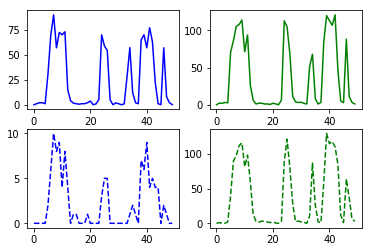

In [4]:

gene_id = 0
plt.subplot(221)
plt.plot(list(range(50)), uu[cell_id, :50], 'b')
plt.subplot(222)
plt.plot(list(range(cell_num)), ul[cell_id, :50], 'g')
plt.subplot(223)
plt.plot(list(range(50)), su[cell_id, :50], 'b--')
plt.subplot(224)
plt.plot(list(range(cell_num)), sl[cell_id, :50], 'g--')


In [5]:
time0_Simulator = time.time()
adata = Simulator(a, b, la, aa, ai, si, be, ga, C0, t_span, n_traj)
time1_Simulator = time.time()

print('Time elapse for Simulator: %.2f'% (time1_Simulator - time0_Simulator))


Time elapse for Simulator: 246.35


In [6]:
# run velocyto 
time0_run_velocyto = time.time()
vlm = run_velocyto(adata)
time1_run_velocyto = time.time()

# # run scvelo
time0_scvelo = time.time()
adata_scvelo = run_scvelo(adata)
scv.tl.recover_dynamics(adata_scvelo)
time1_scvelo = time.time()

# # run our method 
time0_adata_dynamo = time.time()
adata_dynamo = run_dynamo(adata, normalize = False, init_num = 1, sample_method = None)

time1_adata_dynamo = time.time()

# import warnings
# warnings.filterwarnings('ignore')

print('Time elapse for velocyto: %.2f'% (time1_run_velocyto - time0_run_velocyto))
print('Time elapse for scvelo: %.2f'% (time1_scvelo - time0_scvelo))
print('Time elapse for dynamo: %.2f'% (time1_adata_dynamo - time0_adata_dynamo))

# 	p0_range = {'a': [0, 1], 'b': [0, 1], 'la': [0, 1], 'alpha_a': [10, 1000], \
# 			'alpha_i': [0, 10], 'sigma': [0, 1], 'beta': [0, 10], 'gamma': [0, 10]}


Cannot export `.obsm` and `.varm` entries to loom.The loom file will lack these fields:
('X_pca',)



Time elapse for velocyto: 0.40
Time elapse for scvelo: 11.21
Time elapse for dynamo: 2.15


In [7]:
np.corrcoef(aa, adata_scvelo.var['fit_gamma'])[1, 0]
scvelo_coef = [np.corrcoef(aa, adata_scvelo.var['fit_alpha'])[1, 0], 
               np.corrcoef(be, adata_scvelo.var['fit_beta'])[1, 0], 
               np.corrcoef(ga, adata_scvelo.var['fit_gamma'])[1, 0], ]

adata_dynamo.uns['dynamo']["a"].values
a
adata_dynamo.uns['dynamo']["a"].values
a
np.corrcoef(a, list(adata_dynamo.uns['dynamo']["a"].values))
dynamo_coef = [np.corrcoef(a, list(adata_dynamo.uns['dynamo']["a"]))[1, 0], 
               np.corrcoef(b, list(adata_dynamo.uns['dynamo']["b"]))[1, 0], 
               np.corrcoef(la, list(adata_dynamo.uns['dynamo']["la"]))[1, 0],
               np.corrcoef(aa, list(adata_dynamo.uns['dynamo']["alpha_a"]))[1, 0],
               np.corrcoef(ai, list(adata_dynamo.uns['dynamo']["alpha_i"]))[1, 0],
               np.corrcoef(si, list(adata_dynamo.uns['dynamo']["sigma"]))[1, 0],
               np.corrcoef(be, list(adata_dynamo.uns['dynamo']["beta"]))[1, 0],
               np.corrcoef(ga, list(adata_dynamo.uns['dynamo']["gamma"]))[1, 0],

              ]

{'velocyto':      gamma
 0  0.48712, 'scvelo':       alpha      beta     gamma
 0  0.389776 -0.583847  0.317202, 'dynamo':          a         b        la   alpha_a   alpha_i     sigma      beta  \
 0  0.23223  0.477306  0.999979  0.872981  0.211223  0.999527  0.817435   
 
       gamma  
 0  0.624196  }

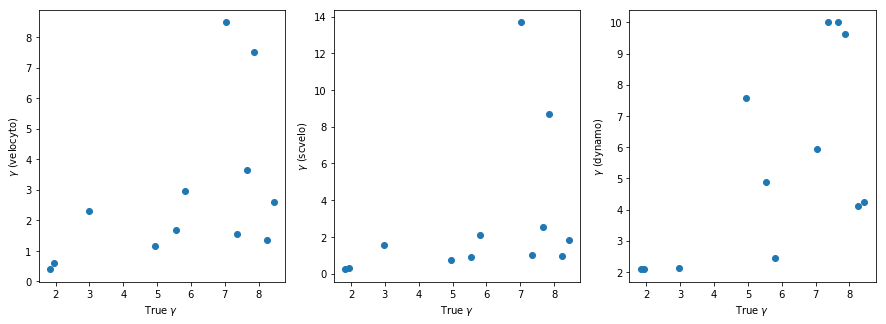

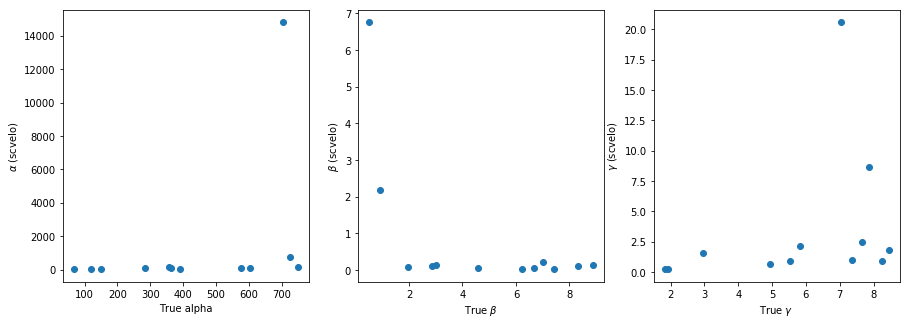

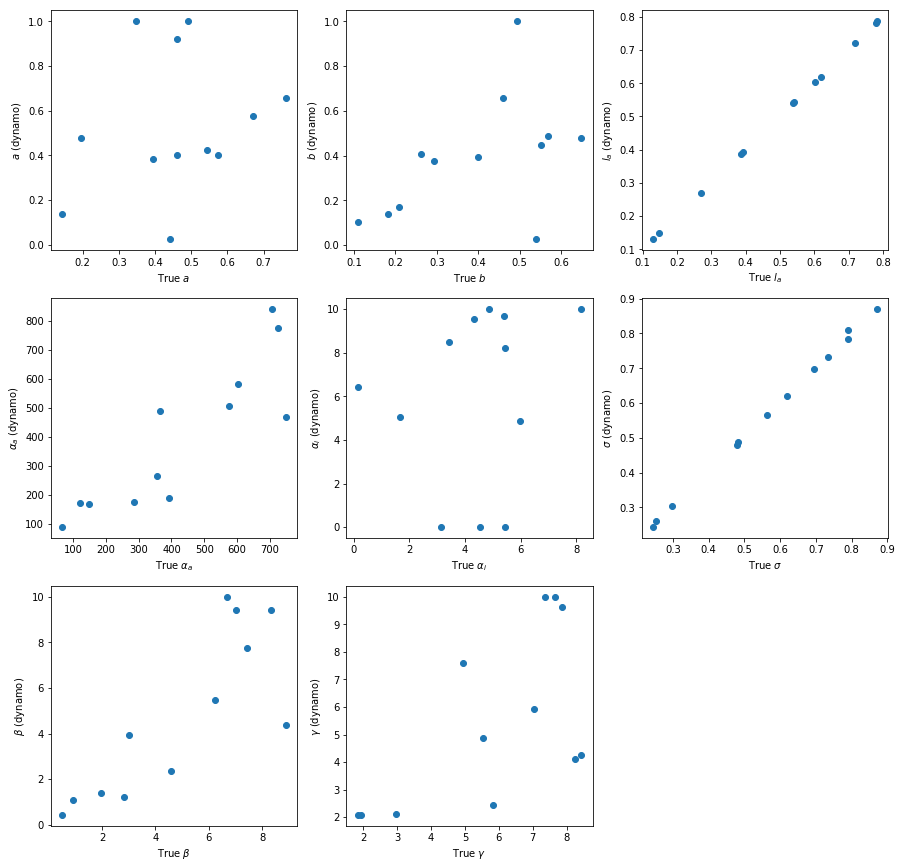

In [8]:
def compare_res(adata, velocyto_res, svelo_res, dynamo_res, a_val, b_val, la_val, alpha_a_val, alpha_i_val, sigma_val, beta_val, gamma_val):
	'''
	function to compare results from velocyto and scvelo with our new method
	0. retrieve gamm or gamma with other parameters from velocyto result or scvelo
	1. plot the correlation between parameters estimated with different methods
	2. calculate the correltion between those parameters
	'''
	# self._offset, self._offset2, self._beta, self._gamma, self._r2, self._velocity_genes

	velocyto_gammas = velocyto_res.gammas
	scvelo_gammas = svelo_res.var['velocity_gamma']

	# scatter plot the true gammas with our result
	plt.subplots(figsize = (15, 5))
	plt.plot()
	plt.subplot(131)
	plt.plot(gamma_val, velocyto_gammas, 'o')
	plt.xlabel(r'True $\gamma$')
	plt.ylabel(r'$\gamma$ (velocyto)')
	plt.subplot(132)
	plt.plot(gamma_val, scvelo_gammas, 'o')
	plt.xlabel(r'True $\gamma$')
	plt.ylabel(r'$\gamma$ (scvelo)')
	plt.subplot(133)
	plt.plot(gamma_val, dynamo_res.uns['dynamo']["gamma"], 'o')
	plt.xlabel(r'True $\gamma$')
	plt.ylabel(r'$\gamma$ (dynamo)')
	plt.savefig("/home/xqiu/proj/dynamo/figures/compare_fitting_parameters1.pdf", bbox_inches='tight')

    # what if we only have a small number of parameters? 
	plt.subplots(figsize = (15, 5))
	plt.plot()
	plt.subplot(131)
	plt.plot(alpha_a_val, svelo_res.var['fit_alpha'], 'o')
	plt.xlabel(r'True alpha')
	plt.ylabel(r'$\alpha$ (scvelo)')
	plt.subplot(132)
	plt.plot(beta_val, svelo_res.var['fit_beta'], 'o')
	plt.xlabel(r'True $\beta$')
	plt.ylabel(r'$\beta$ (scvelo)')
	plt.subplot(133)
	plt.plot(gamma_val, svelo_res.var['fit_gamma'], 'o')
	plt.xlabel(r'True $\gamma$')
	plt.ylabel(r'$\gamma$ (scvelo)')
	plt.savefig("/home/xqiu/proj/dynamo/figures/compare_fitting_parameters2.pdf", bbox_inches='tight')

    #     param_out = pd.DataFrame(index=adata.var.index, columns=['a', 'b', 'la', 'alpha_a', 'alpha_i', 'sigma', 'beta', 'gamma'])
    # what if we only have a small number of parameters? 
	plt.subplots(figsize = (15, 15))
	plt.subplot(331)
	plt.plot(a_val, adata.uns['dynamo']["a"], 'o')
	plt.xlabel(r'True $a$')
	plt.ylabel(r'$a$ (dynamo)')
	plt.subplot(332)
	plt.plot(b_val, adata.uns['dynamo']["b"], 'o')
	plt.xlabel(r'True $b$')
	plt.ylabel(r'$b$ (dynamo)')
	plt.subplot(333)
	plt.plot(la_val, adata.uns['dynamo']["la"], 'o')
	plt.xlabel(r'True $l_a$')
	plt.ylabel(r'$l_a$ (dynamo)')
	plt.subplot(334)
	plt.plot(alpha_a_val, adata.uns['dynamo']["alpha_a"], 'o')
	plt.xlabel(r'True $\alpha_a$')
	plt.ylabel(r'$\alpha_a$ (dynamo)')
	plt.subplot(335)
	plt.plot(alpha_i_val, adata.uns['dynamo']["alpha_i"], 'o')
	plt.xlabel(r'True $\alpha_i$')
	plt.ylabel(r'$\alpha_i$ (dynamo)')
	plt.subplot(336)
	plt.plot(sigma_val, adata.uns['dynamo']["sigma"], 'o')
	plt.xlabel(r'True $\sigma$')
	plt.ylabel(r'$\sigma$ (dynamo)')
	plt.subplot(337)
	plt.plot(beta_val, adata.uns['dynamo']["beta"], 'o')
	plt.xlabel(r'True $\beta$')
	plt.ylabel(r'$\beta$ (dynamo)')
	plt.subplot(338)
	plt.plot(gamma_val, adata.uns['dynamo']["gamma"], 'o')
	plt.xlabel(r'True $\gamma$')
	plt.ylabel(r'$\gamma$ (dynamo)')
	plt.savefig("/home/xqiu/proj/dynamo/figures/compare_fitting_parameters3.pdf", bbox_inches='tight')
	scipy.io.savemat("/home/xqiu/proj/dynamo/data/benchmark_res.mat", {"gamma_val": gamma_val, 
                                                                       "velocyto_gammas": velocyto_gammas,
                                                                       "scvelo_alpha_a_val": svelo_res.var['fit_alpha'],
                                                                       "beta_val": beta_val,"scvelo_beta_val": svelo_res.var['fit_beta'],
                                                                       "scvelo_gamma_val": svelo_res.var['fit_gamma'],
                                                                       'a': a_val, 'dynamo_a': list(dynamo_res.uns['dynamo']["a"]), 
                                                                       'b': b_val, 'dynamo_b': list(dynamo_res.uns['dynamo']["b"]), 
                                                                       'la': la_val, 'dynamo_la': list(dynamo_res.uns['dynamo']["la"]),
                                                                       'alpha_a': alpha_a_val, 'dynamo_alpha_a': list(dynamo_res.uns['dynamo']["alpha_a"]),
                                                                       'alpha_i': alpha_i_val, 'dynamo_alpha_i': list(dynamo_res.uns['dynamo']["alpha_i"]),
                                                                       'sigma': sigma_val, 'dynamo_sigma': list(dynamo_res.uns['dynamo']["sigma"]),
                                                                       'beta': beta_val, 'dynamo_beta': list(dynamo_res.uns['dynamo']["beta"]),
                                                                       'gamma': gamma_val, 'dynamo_gamma': list(dynamo_res.uns['dynamo']["gamma"])})

	velocyto_coef = {"gamma": np.corrcoef(gamma_val, velocyto_gammas)[1, 0]}
	scvelo_coef = {"alpha": np.corrcoef(alpha_a_val, svelo_res.var['fit_alpha'])[1, 0], 
                   "beta": np.corrcoef(beta_val, svelo_res.var['fit_beta'])[1, 0], 
                   "gamma": np.corrcoef(gamma_val, svelo_res.var['fit_gamma'])[1, 0], }
    
	dynamo_coef = {'a': np.corrcoef(a_val, list(dynamo_res.uns['dynamo']["a"]))[1, 0], 
	               'b': np.corrcoef(b_val, list(dynamo_res.uns['dynamo']["b"]))[1, 0], 
	               'la': np.corrcoef(la_val, list(dynamo_res.uns['dynamo']["la"]))[1, 0],
	               'alpha_a': np.corrcoef(alpha_a_val, list(dynamo_res.uns['dynamo']["alpha_a"]))[1, 0],
	               'alpha_i': np.corrcoef(alpha_i_val, list(dynamo_res.uns['dynamo']["alpha_i"]))[1, 0],
	               'sigma': np.corrcoef(sigma_val, list(dynamo_res.uns['dynamo']["sigma"]))[1, 0],
	               'beta': np.corrcoef(beta_val, list(dynamo_res.uns['dynamo']["beta"]))[1, 0],
	               'gamma': np.corrcoef(gamma_val, list(dynamo_res.uns['dynamo']["gamma"]))[1, 0],

	              }
    
	return {'velocyto': pd.DataFrame.from_dict(velocyto_coef, orient = 'index').T, \
	'scvelo': pd.DataFrame.from_dict(scvelo_coef, orient = 'index').T, \
	'dynamo': pd.DataFrame.from_dict(dynamo_coef, orient = 'index').T}


compare_res(adata, vlm, adata_scvelo, adata_dynamo, a, b, la, aa, ai, si, be, ga)
